***Model Prediction based on KMeans Clustering***

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

# Load the data
df = pd.read_csv("BankChurners.csv")

# Exclude Naive Bayes classifier-related columns
naive_bayes_columns = [
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
]
df.drop(naive_bayes_columns, axis=1, inplace=True)

# Define the target and features
y = df["Attrition_Flag"].apply(lambda x: 1 if x == 'Attrited Customer' else 0)
X = df.drop("Attrition_Flag", axis=1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Preprocess the data by encoding categorical variables
cat_columns = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
preprocessor = ColumnTransformer(
    [('cat', OneHotEncoder(), cat_columns)],
    remainder='passthrough'
)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Clustering the resampled training data
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X_train_resampled)

# Add cluster labels to the resampled training data for analysis
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=[f'feature_{i}' for i in range(X_train_resampled.shape[1])])
X_train_resampled_df['cluster'] = kmeans.labels_
X_train_resampled_df['churn'] = y_train_resampled

# Analyze churn rate by cluster
churn_rate_by_cluster = X_train_resampled_df.groupby('cluster')['churn'].mean()
print("Churn Rate by Cluster:")
print(churn_rate_by_cluster)

# Reverse the one-hot encoding to interpret the cluster centers
cat_processor = preprocessor.named_transformers_['cat']
feature_names = sum([list(map(lambda x: f'{col}_{x}', cat_processor.categories_[i])) 
                     for i, col in enumerate(cat_columns)], [])
feature_names += [col for col in X_train.columns if col not in cat_columns]

# Create a DataFrame for easier interpretation of cluster centers
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=feature_names)
print("Cluster Centers DataFrame:")
print(cluster_centers_df)


Churn Rate by Cluster:
cluster
0    0.521191
1    0.439372
2    0.476090
Name: churn, dtype: float64
Cluster Centers DataFrame:
   Gender_F  Gender_M  Education_Level_College  Education_Level_Doctorate  \
0  0.562509  0.437491                 0.095369                   0.049198   
1  0.517710  0.482290                 0.112188                   0.043586   
2  0.528262  0.471738                 0.103988                   0.053598   

   Education_Level_Graduate  Education_Level_High School  \
0                  0.298680                     0.202977   
1                  0.314601                     0.191939   
2                  0.307501                     0.209288   

   Education_Level_Post-Graduate  Education_Level_Uneducated  \
0                       0.050074                    0.149091   
1                       0.059301                    0.136764   
2                       0.047342                    0.137901   

   Education_Level_Unknown  Marital_Status_Divorced  ...  \
0    

***Evaluate Clustering Performance***

In [25]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(X_train_resampled, kmeans.labels_)
print("The average silhouette score is:", silhouette_avg)


The average silhouette score is: 0.8361445369170365


***Explore and Visualize Clusters***

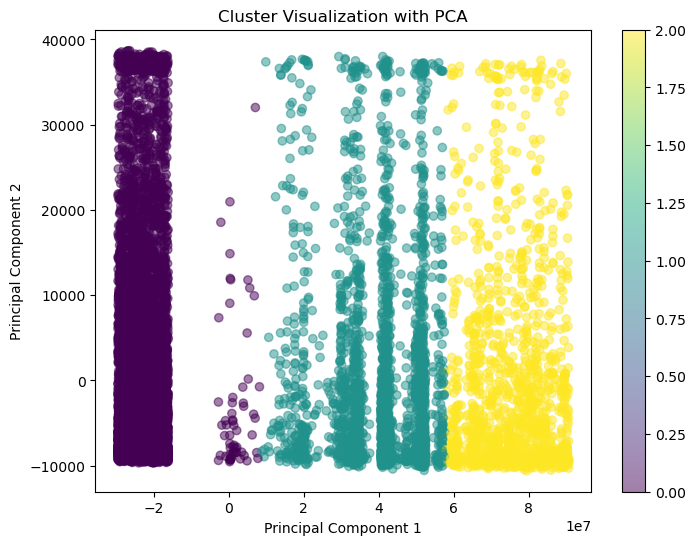

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization with PCA')
plt.show()


***Cluster Descrptive Analysis***

In [27]:
# Assuming you have a DataFrame 'X_train_resampled_df' with relevant features and 'cluster' labels
cluster_means = X_train_resampled_df.groupby('cluster').mean()
print("Mean values per cluster for all features:")
print(cluster_means)

cluster_counts = X_train_resampled_df['cluster'].value_counts()
print("\nNumber of data points per cluster:")
print(cluster_counts)


Mean values per cluster for all features:
         feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
cluster                                                                     
0         0.562509   0.437491   0.095369   0.049198   0.298680   0.202977   
1         0.517710   0.482290   0.112188   0.043586   0.314601   0.191939   
2         0.528262   0.471738   0.103988   0.053598   0.307501   0.209288   

         feature_6  feature_7  feature_8  feature_9  ...  feature_29  \
cluster                                              ...               
0         0.050074   0.149091   0.154611   0.071457  ...    2.674758   
1         0.059301   0.136764   0.141622   0.080004  ...    2.688718   
2         0.047342   0.137901   0.140383   0.072517  ...    2.619439   

          feature_30  feature_31   feature_32  feature_33   feature_34  \
cluster                                                                  
0        8066.034249  949.238643  7116.795606    0.724300  3887